<a href="https://colab.research.google.com/github/Uemerson/experiments-tensorflow/blob/main/cnn_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST dataset - CNN with MaxPooling

In [ ]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Reshape the data to have a single channel
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# Normalize data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Create the model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model on first 50% of the training set
x_train = x_train[:int(0.5 * len(x_train))]
y_train = y_train[:int(0.5 * len(y_train))]

# Train the model
r = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test))


11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/10
938/938 [==============================] - 26s 10ms/step - loss: 0.2111 - accuracy: 0.9347 - val_loss: 0.0607 - val_accuracy: 0.9822
Epoch 2/10
938/938 [==============================] - 5s 5ms/step - loss: 0.0712 - accuracy: 0.9777 - val_loss: 0.0461 - val_accuracy: 0.9849
Epoch 3/10
938/938 [==============================] - 6s 6ms/step - loss: 0.0513 - accuracy: 0.9837 - val_loss: 0.0431 - val_accuracy: 0.9858
Epoch 4/10
938/938 [==============================] - 5s 5ms/step - loss: 0.0407 - accuracy: 0.9860 - val_loss: 0.0314 - val_accuracy: 0.9892
Epoch 5/10
938/938 [==============================] - 6s 6ms/step - loss: 0.0320 - accuracy: 0.9892 - val_loss: 0.0338 - val_accuracy: 0.9901
Epoch 6/10
938/938 [==============================] - 6s 6ms/step - loss: 0.0267 - accuracy: 0.9917 - val_loss: 0.0367 - val_accuracy: 0.9881
Epoch 7/10
938/938 [==============================] - 6s 6ms/step - loss: 0.0229 

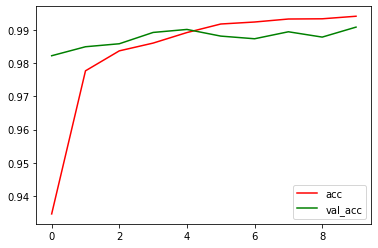

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc', color='red')
plt.plot(r.history['val_accuracy'], label='val_acc', color='green')
plt.legend()

In [ ]:
#  Get the accuracy of the last epoch
r.history['accuracy'][-1]

0.9940666556358337

In [ ]:
import numpy as np

# Make predictions on the test set
y_pred = model.predict(x_test)

# Get the class labels with highest probability
y_pred_labels = np.argmax(y_pred, axis=1)

313/313 [==============================] - 1s 2ms/step


1/1 [==============================] - 0s 60ms/step


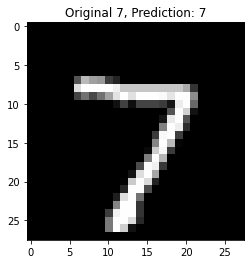

1/1 [==============================] - 0s 19ms/step


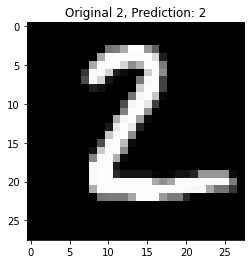

1/1 [==============================] - 0s 20ms/step


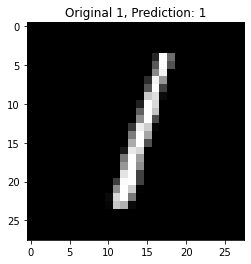

1/1 [==============================] - 0s 21ms/step


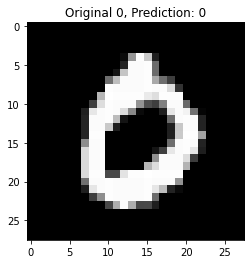

1/1 [==============================] - 0s 22ms/step


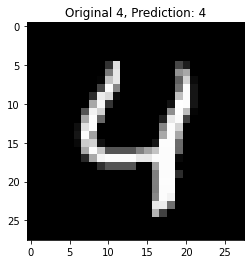

1/1 [==============================] - 0s 19ms/step


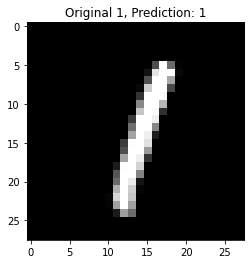

In [ ]:
for i in range(0,6):
  img = x_test[i]
  img = np.expand_dims(img, axis=0)

  # Make prediction on individual image
  prediction = model.predict(img)

  # Get the class label with highest probability
  prediction_label = np.argmax(prediction, axis=1)
  
  # Get the original label of the image
  original_label = y_test[i]

  # Plot the image and the prediction
  plt.imshow(img.reshape(28, 28), cmap='gray')
  plt.title('Original {}, Prediction: {}'.format(np.where(original_label == 1)[0][0], prediction_label[0]))
  plt.show()

# MNIST dataset - CNN with BPCA Layer

11490434/11490434 [==============================] - 1s 0us/step


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Instructions for updating:
Use fn_output_signature instead


Epoch 1/10
938/938 [==============================] - 87s 39ms/step - loss: 2.3016 - accuracy: 0.1122 - val_loss: 2.3011 - val_accuracy: 0.1135
Epoch 2/10
938/938 [==============================] - 18s 19ms/step - loss: 2.3011 - accuracy: 0.1141 - val_loss: 2.3011 - val_accuracy: 0.1135
Epoch 3/10
938/938 [==============================] - 15s 16ms/step - loss: 2.3011 - accuracy: 0.1141 - val_loss: 2.3011 - val_accuracy: 0.1135
Epoch 4/10
938/938 [==============================] - 15s 17ms/step - loss: 2.3011 - accuracy: 0.1141 - val_loss: 2.3011 - val_accuracy: 0.1135
Epoch 5/10
938/938 [==============================] - 16s 17ms/step - loss: 2.3011 - accuracy: 0.1141 - val_loss: 2.3011 - val_accuracy: 0.1135
Epoch 6/10
938/938 [==============================] - 17s 18ms/step - loss: 2.3011 - accuracy: 0.1141 - val_loss: 2.3010 - val_accuracy: 0.1135
Epoch 7/10
938/938 [==============================] - 18s 19ms/step - loss: 2.3011 - accuracy: 0.1141 - val_loss: 2.3011 - val_accuracy:

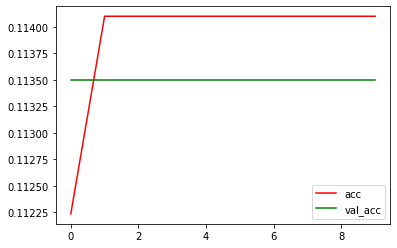

accuracy: 0.11410000175237656
1/1 [==============================] - 17s 17s/step


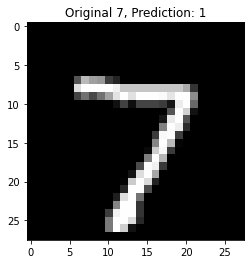

1/1 [==============================] - 0s 19ms/step


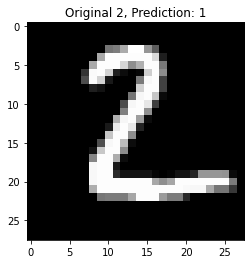

1/1 [==============================] - 0s 20ms/step


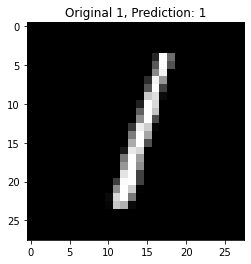

1/1 [==============================] - 0s 31ms/step


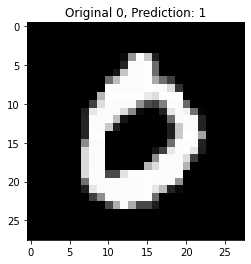

1/1 [==============================] - 0s 32ms/step


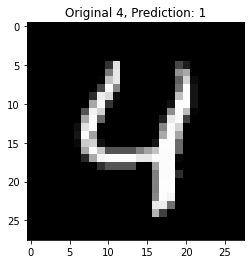

1/1 [==============================] - 0s 34ms/step


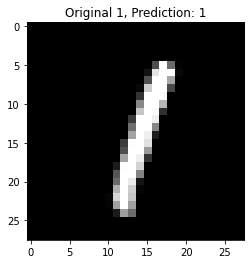

In [1]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

class BPCALayer(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, stride=2, n_components=1):
        super(BPCALayer, self).__init__()
        self.pool_size = pool_size
        self.stride = stride
        self.n_components = n_components

    def call(self, inputs):
      def bpca_pooling(feature_map):
        # Compute the region of interest        
        feature_map_height = int(feature_map.shape[0])
        feature_map_width  = int(feature_map.shape[1])
        feature_map_channels = int(feature_map.shape[2])

        results = tf.TensorArray(tf.float32, size=feature_map_channels)
        for channel in range(0, feature_map_channels):
          n = feature_map_height
          m = feature_map_width

          input = tf.reshape(feature_map[:, :, channel], [int(n), int(m)])

          # make blocks
          output_matrix = []
          for i in range(0, n, self.stride):
            for j in range(0, m, self.stride):
                # fix out of bounds
                if i + self.pool_size > n or j + self.pool_size > m:
                    continue
                output_matrix.append(input[i:i + self.pool_size, j:j + self.pool_size])

          output_matrix = tf.convert_to_tensor(output_matrix, tf.float32)
          output_matrix = tf.reshape(output_matrix, (output_matrix.shape[0], output_matrix.shape[1]*output_matrix.shape[2]))

          n_components = self.n_components
          data = tf.cast(output_matrix, tf.float32)

          # Normalize the data by subtracting the mean and dividing by the standard deviation
          mean = tf.reduce_mean(data, axis=0)
          std = tf.math.reduce_std(data, axis=0)
          data = (data - mean) / std

          # Perform the Singular Value Decomposition (SVD) on the data
          s, u, v = tf.linalg.svd(data)

          # Extract the first n principal components from the matrix v
          pca_components = v[:, :n_components]

          # Perform the PCA transformation on the data
          transformed_data = tf.matmul(data, pca_components)

          results.write(channel, tf.reshape(transformed_data, [n // self.pool_size, m // self.pool_size]))

        result = results.stack()
        return tf.reshape(result, [n // self.pool_size, m // self.pool_size, feature_map_channels])

      pooled = tf.map_fn(bpca_pooling, inputs, dtype=tf.float32)
      return pooled

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Reshape the data to have a single channel
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# Normalize data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Create the model
model = Sequential()
# model.add(tf.keras.layers.InputLayer((28, 28, 1), batch_size=32))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BPCALayer()) # replace MaxPooling2D with BPCALayer
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model on first 50% of the training set
x_train = x_train[:int(0.5 * len(x_train))]
y_train = y_train[:int(0.5 * len(y_train))]

# Train the model
r = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test))

# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc', color='red')
plt.plot(r.history['val_accuracy'], label='val_acc', color='green')
plt.legend()
plt.show()

#  Get the accuracy of the last epoch
print(f"accuracy: {r.history['accuracy'][-1]}")

for i in range(0,6):
  img = x_test[i]
  img = np.expand_dims(img, axis=0)

  # Make prediction on individual image
  prediction = model.predict(img)

  # Get the class label with highest probability
  prediction_label = np.argmax(prediction, axis=1)
  
  # Get the original label of the image
  original_label = y_test[i]

  # Plot the image and the prediction
  plt.imshow(img.reshape(28, 28), cmap='gray')
  plt.title('Original {}, Prediction: {}'.format(np.where(original_label == 1)[0][0], prediction_label[0]))
  plt.show()